# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import cv2
import csv
import random
import shutil
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Загружаем файл с атрибутами
df_attr = pd.read_csv('list_attr_celeba.csv')
df_attr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   image_id             202599 non-null  object
 1   5_o_Clock_Shadow     202599 non-null  int64 
 2   Arched_Eyebrows      202599 non-null  int64 
 3   Attractive           202599 non-null  int64 
 4   Bags_Under_Eyes      202599 non-null  int64 
 5   Bald                 202599 non-null  int64 
 6   Bangs                202599 non-null  int64 
 7   Big_Lips             202599 non-null  int64 
 8   Big_Nose             202599 non-null  int64 
 9   Black_Hair           202599 non-null  int64 
 10  Blond_Hair           202599 non-null  int64 
 11  Blurry               202599 non-null  int64 
 12  Brown_Hair           202599 non-null  int64 
 13  Bushy_Eyebrows       202599 non-null  int64 
 14  Chubby               202599 non-null  int64 
 15  Double_Chin          202599 non-nu

In [4]:
df_attr.rename(columns={'image_id': 'filename'}, inplace=True)

In [3]:
# Загружаем файл с идентификаторами
df_id = pd.read_csv('identity_CelebA.txt', sep=' ', header=None, names=['filename', 'person_id'])
df_id.info()
df_id.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   filename   202599 non-null  object
 1   person_id  202599 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.1+ MB


,filename,person_id
0,000001.jpg,2880
1,000002.jpg,2937
2,000003.jpg,8692
3,000004.jpg,5805
4,000005.jpg,9295


In [5]:
person_counts = df_id['person_id'].value_counts().reset_index()
person_counts.columns = ['person_id', 'image_count']
person_counts.head()

,person_id,image_count
0,3227,35
1,3782,35
2,2820,35
3,3699,34
4,3745,34


Для задачи распознования лиц важны демографические признаки, эмоции, аксессуары, макияж. Выбираем пол 'Male', возраст 'Young', этническая принадлежность 'Black_Hair', 'Blond_Hair', 'Brown_Hair', улыбка 'Smiling', очки 'Eyeglasses', макияж 'Heavy_Makeup'

In [6]:
df_attr[['Male', 'Young', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Smiling', 'Eyeglasses', 'Heavy_Makeup']] = df_attr[['Male', 'Young', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Smiling', 'Eyeglasses', 'Heavy_Makeup']].astype(int)

In [8]:
attributes=['Male', 'Young', 'Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Smiling', 'Eyeglasses', 'Heavy_Makeup']
df_attr_processed = df_attr.copy()
# Объединяем атрибуты с идентификаторами
merged_df = pd.merge(
        df_id,
        df_attr_processed[['filename'] + attributes],  # Берем только нужные атрибуты
        on='filename',
        how='inner'
    )

merged_df = pd.merge(
        merged_df,
        person_counts,
        on='person_id',
        how='left'
    )

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   filename      202599 non-null  object
 1   person_id     202599 non-null  int64 
 2   Male          202599 non-null  int64 
 3   Young         202599 non-null  int64 
 4   Black_Hair    202599 non-null  int64 
 5   Blond_Hair    202599 non-null  int64 
 6   Brown_Hair    202599 non-null  int64 
 7   Smiling       202599 non-null  int64 
 8   Eyeglasses    202599 non-null  int64 
 9   Heavy_Makeup  202599 non-null  int64 
 10  image_count   202599 non-null  int64 
dtypes: int64(10), object(1)
memory usage: 17.0+ MB


In [9]:
#отфильтруем персоны, у которых больше 25 изображений в датасете
df = merged_df[merged_df['image_count'] > 25].copy()
len(df)

97314

In [10]:
# Преобразуем -1 в 0 для удобства
df = df.replace(-1, 0)

# Создаем стратификационную колонку
df['strata'] = df['Male'].astype(str) + '_' + \
               df['Young'].astype(str) + '_' + \
               df['Black_Hair'].astype(str) + '_' + \
               df['Blond_Hair'].astype(str) + '_' + \
               df['Brown_Hair'].astype(str) + '_' + \
               df['Smiling'].astype(str) + '_' + \
               df['Eyeglasses'].astype(str) + '_' + \
               df['Heavy_Makeup'].astype(str)


print("Распределение по стратам:")
print(df['strata'].value_counts())

# Стратифицированная выборка
sampled_df = df.groupby('strata', group_keys=False).apply(
    lambda x: x.sample(min(len(x), int(75000 * len(x) / len(df))),
                      random_state=42),include_groups=False
).sample(frac=1, random_state=42).head(75000)

print(f"\nВыбрано {len(sampled_df)} изображений")

Распределение по стратам:
strata
0_1_0_0_0_0_0_1    6591
1_1_0_0_0_0_0_0    5596
0_1_0_0_0_1_0_1    5588
0_1_0_1_0_1_0_1    5318
1_1_1_0_0_0_0_0    4682
                   ... 
1_0_0_1_1_1_1_0       1
1_0_1_0_1_0_1_0       1
0_0_0_1_0_0_1_1       1
0_0_1_0_1_0_0_1       1
0_0_1_0_0_0_1_1       1
Name: count, Length: 129, dtype: int64

Выбрано 74933 изображений


In [14]:
def find_image(image_id, base_path):

    base_path = Path(base_path)

    for part_num in range(1, 22):
        possible_path = base_path / f'Part {part_num}' / f'Part {part_num}' / image_id
        if possible_path.exists():
            return str(possible_path)

    return None

def copy_images_with_min_count(source_dir, target_dir, df, min_count=25):
    """
    Копирум фотографии персон, у которых больше min_count изображений

    Parameters:
    -----------
    source_dir : str
        Исходная директория с фотографиями
    target_dir : str
        Целевая директория для копирования
    df : pandas.DataFrame
        Датафрейм с колонками ['filename', 'person_id']
    min_count : int
        Минимальное количество изображений для персоны (по умолчанию 25)
    """

    # Создаем целевую директорию, если она не существует
    Path(target_dir).mkdir(parents=True, exist_ok=True)

    # Группируем по person_id и считаем количество изображений
    person_counts = df['person_id'].value_counts()

    # Получаем список персон с более чем min_count изображений
    persons_with_many_images = person_counts[person_counts > min_count].index.tolist()

    print(f"Найдено персон с > {min_count} изображений: {len(persons_with_many_images)}")

    # Фильтруем датафрейм только для нужных персон
    filtered_df = df[df['person_id'].isin(persons_with_many_images)]
    selected_images = filtered_df['filename'].tolist()

    # Счетчики для статистики
    total_images = 0
    copied_images = 0
    missing_images = 0

    # Копируем изображения
    with tqdm(total=len(selected_images), desc="Копирование") as pbar:
        for image_id in selected_images:
            # Находим исходный файл
            source_path = find_image(image_id, source_dir)

            total_images += 1

            target_path = os.path.join(target_dir, image_id)

            # Проверяем, существует ли исходный файл
            if os.path.exists(source_path):
                try:
                    # Копируем файл
                    shutil.copy2(source_path, target_path)
                    copied_images += 1

                except Exception as e:
                    print(f"Ошибка при копировании {source_path}: {e}")
            else:
                missing_images += 1
                print(f"Файл не найден: {source_path}")
            pbar.update(1)


    # Выводим статистику
    print("\n" + "="*50)
    print("СТАТИСТИКА:")
    print(f"Всего персон с > {min_count} изображений: {len(persons_with_many_images)}")
    print(f"Всего изображений для копирования: {total_images}")
    print(f"Успешно скопировано: {copied_images}")
    print(f"Отсутствуют файлы: {missing_images}")
    print(f"Целевая директория: {target_dir}")

    # Возвращаем DataFrame с скопированными изображениями
    return filtered_df.copy()


In [15]:
if __name__ == "__main__":


    result_df = copy_images_with_min_count(
        source_dir = 'archive',
        target_dir = 'selected_images',
        df = sampled_df,
        min_count = 25
    )

    # Вариант 2: Копирование с созданием папок для каждой персоны
    # person_files = copy_images_with_folders(
    #     source_dir=SOURCE_DIR,
    #     target_dir=TARGET_DIR,
    #     df=df,
    #     min_count=25
    # )

    # Сохраняем информацию о скопированных файлах
    result_df.to_csv(os.path.join('selected_images', 'selected_images_info.csv'), index=False)

Найдено персон с > 25 изображений: 397


Копирование: 100%|██████████| 10528/10528 [00:39<00:00, 266.44it/s]


СТАТИСТИКА:
Всего персон с > 25 изображений: 397
Всего изображений для копирования: 10528
Успешно скопировано: 10528
Отсутствуют файлы: 0
Целевая директория: selected_images


Обрезаем изображения по размеру bbox и пересчитываем координаты ключевых точек

Начинаем обработку...
Исходная директория: selected_images
Выходная директория: cropped_images
Найдено изображений: 10529

Загрузка landmarks и bounding boxes...
  Загружено landmarks: 10528
  Загружено bbox: 202599
  Общих изображений (landmarks + bbox): 10528

Обработка и сохранение изображений...
Начинаем обработку 10528 изображений...


Обработка изображений: 100%|██████████| 10528/10528 [01:14<00:00, 141.94img/s]



✓ Основные координаты сохранены в: cropped_images\cropped_landmarks.csv
  Размер файла: 1,037,649 байт

Визуализация результатов...


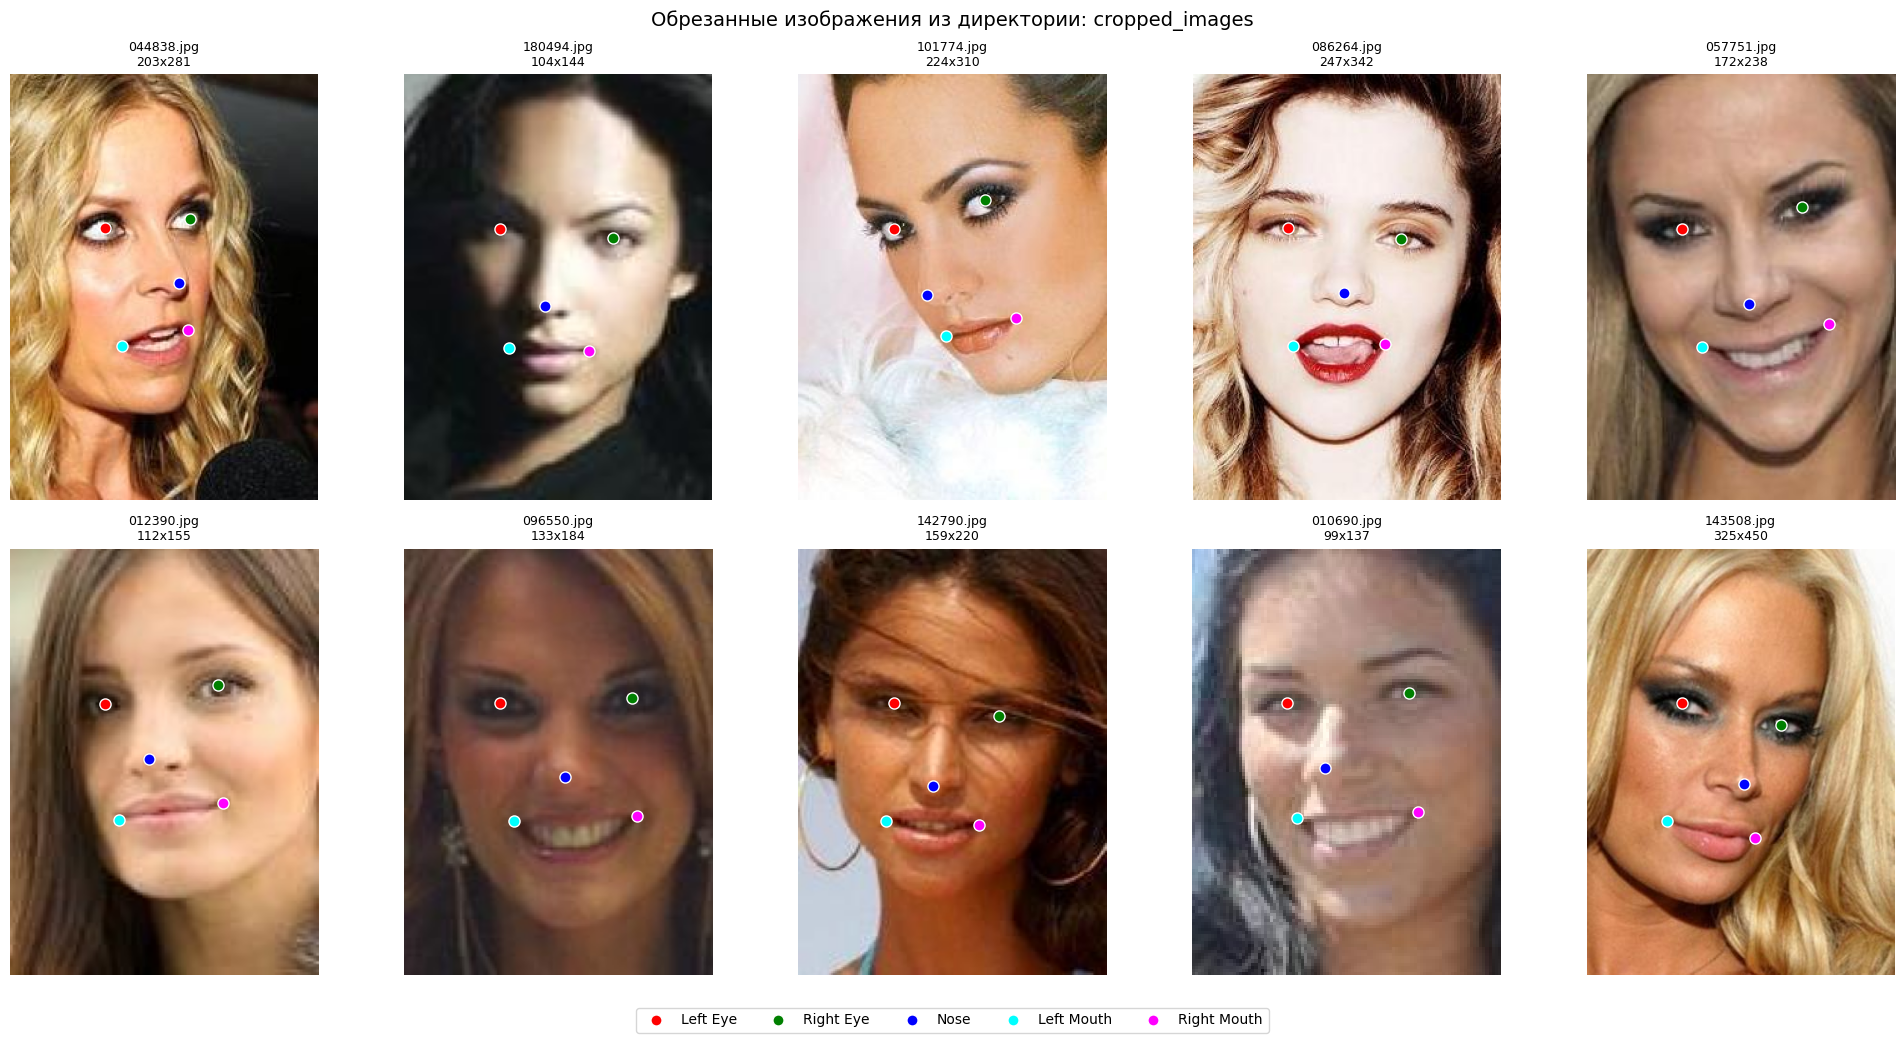


СТАТИСТИКА ОБРАБОТКИ
Всего обработано изображений: 10528
Директория с результатами: cropped_images
Изображений в директории: 10528

Первые 5 строк из CSV файла:
     image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  original_width  original_height  bbox_x  bbox_y  bbox_width  bbox_height  cropped_width  cropped_height
0  000003.jpg       28.0       45.0        48.0        46.0    47.0    62.0         19.0         75.0          35.0          81.0             500              281     216      59          91          126             91             126
1  000004.jpg      174.0      282.0       362.0       282.0   308.0   430.0        140.0        499.0         293.0         499.0            1648             2464     622     257         564          781            564             781
2  000016.jpg       87.0      142.0       189.0       140.0   127.0   210.0         87.0        247.0         180.0         249.0    

In [16]:
def load_landmarks(landmarks_file, selected_images):
    """Загружаем координаты точек только для выбранных изображений"""
    landmarks_dict = {}

    with open(landmarks_file, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) < 11:
                continue

            img_name = parts[0]

            if img_name in selected_images:
                coords = list(map(int, parts[1:11]))
                landmarks_dict[img_name] = coords

    return landmarks_dict

def load_bboxes(bbox_file):
    """Загружаем bounding boxes из CSV файла"""
    try:
        df = pd.read_csv(bbox_file)
        bbox_dict = {}
        for _, row in df.iterrows():
            bbox_dict[row['image_id']] = {
                'x_1': row['x_1'],
                'y_1': row['y_1'],
                'width': row['width'],
                'height': row['height']
            }
        return bbox_dict
    except Exception as e:
        print(f"Ошибка при чтении файла bbox: {e}")
        return {}

def crop_and_adjust_landmarks(image, landmarks, bbox):
    """Обрезаем изображение и пересчитываем координаты точек"""
    x1 = bbox['x_1']
    y1 = bbox['y_1']
    width = bbox['width']
    height = bbox['height']

    # Проверяем границы
    img_width, img_height = image.size

    x1 = max(0, min(x1, img_width - 1))
    y1 = max(0, min(y1, img_height - 1))
    width = min(width, img_width - x1)
    height = min(height, img_height - y1)

    # Обрезаем изображение
    cropped_img = image.crop((x1, y1, x1 + width, y1 + height))

    # Пересчитываем координаты точек
    adjusted_landmarks = []
    for i in range(0, len(landmarks), 2):
        new_x = landmarks[i] - x1
        new_y = landmarks[i + 1] - y1
        adjusted_landmarks.extend([new_x, new_y])

    return cropped_img, adjusted_landmarks, (x1, y1, width, height)

def save_cropped_images_and_landmarks(images_dir, output_dir, landmarks_dict, bbox_dict):
    """Сохраняем обрезанные изображения и координаты точек"""

    # Создаем выходную директорию
    os.makedirs(output_dir, exist_ok=True)

    # Получаем список изображений для обработки
    images_to_process = [
        img_name for img_name in os.listdir(images_dir)
        if img_name in landmarks_dict and img_name in bbox_dict
    ]

    if not images_to_process:
        print("Нет изображений для обработки!")
        return []

    # Списки для данных
    all_landmarks_data = []
    processed_images = []
    error_images = []

    print(f"Начинаем обработку {len(images_to_process)} изображений...")

    # Обрабатываем все изображения с прогресс-баром
    for img_name in tqdm(images_to_process, desc="Обработка изображений", unit="img"):
        try:
            # Загружаем оригинальное изображение
            img_path = os.path.join(images_dir, img_name)
            original_img = Image.open(img_path)

            # Получаем landmarks и bbox
            original_landmarks = landmarks_dict[img_name]
            bbox = bbox_dict[img_name]

            # Обрезаем и пересчитываем точки
            cropped_img, adjusted_landmarks, bbox_info = crop_and_adjust_landmarks(
                original_img, original_landmarks, bbox
            )

            # Сохраняем обрезанное изображение
            output_path = os.path.join(output_dir, img_name)
            cropped_img.save(output_path)

            # Сохраняем данные для CSV
            landmarks_data = {
                'image_id': img_name,
                'lefteye_x': float(adjusted_landmarks[0]),
                'lefteye_y': float(adjusted_landmarks[1]),
                'righteye_x': float(adjusted_landmarks[2]),
                'righteye_y': float(adjusted_landmarks[3]),
                'nose_x': float(adjusted_landmarks[4]),
                'nose_y': float(adjusted_landmarks[5]),
                'leftmouth_x': float(adjusted_landmarks[6]),
                'leftmouth_y': float(adjusted_landmarks[7]),
                'rightmouth_x': float(adjusted_landmarks[8]),
                'rightmouth_y': float(adjusted_landmarks[9]),
                'original_width': int(original_img.width),
                'original_height': int(original_img.height),
                'bbox_x': int(bbox_info[0]),
                'bbox_y': int(bbox_info[1]),
                'bbox_width': int(bbox_info[2]),
                'bbox_height': int(bbox_info[3]),
                'cropped_width': int(cropped_img.width),
                'cropped_height': int(cropped_img.height)
            }

            all_landmarks_data.append(landmarks_data)
            processed_images.append(img_name)

        except Exception as e:
            error_images.append((img_name, str(e)))

    # Сохраняем координаты в CSV файл
    if all_landmarks_data:
        df = pd.DataFrame(all_landmarks_data)
        csv_path = os.path.join(output_dir, 'cropped_landmarks.csv')

        # Определяем порядок столбцов
        columns_order = [
            'image_id',
            'lefteye_x', 'lefteye_y',
            'righteye_x', 'righteye_y',
            'nose_x', 'nose_y',
            'leftmouth_x', 'leftmouth_y',
            'rightmouth_x', 'rightmouth_y',
            'original_width', 'original_height',
            'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height',
            'cropped_width', 'cropped_height'
        ]

        df = df[columns_order]

        # Проверяем и создаем необходимые колонки
        for col in columns_order:
            if col not in df.columns:
                print(f"Предупреждение: колонка {col} отсутствует в данных")

        # Сохраняем основной CSV
        df.to_csv(csv_path, index=False)
        print(f"\n✓ Основные координаты сохранены в: {csv_path}")
        print(f"  Размер файла: {os.path.getsize(csv_path):,} байт")

    else:
        print("\n⚠ Внимание: не удалось обработать ни одного изображения!")

    return processed_images

def visualize_results(output_dir, num_samples=10):
    """Визуализируем результаты обработки"""

    # Загружаем сохраненные координаты
    csv_path = os.path.join(output_dir, 'cropped_landmarks.csv')
    if not os.path.exists(csv_path):
        print(f"Файл координатов не найден: {csv_path}")
        return

    df = pd.read_csv(csv_path)

    # Получаем список обработанных изображений
    available_images = []
    for img_name in os.listdir(output_dir):
        if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
            if img_name in df['image_id'].values:
                available_images.append(img_name)

    if not available_images:
        print("Нет изображений для отображения")
        return

    # Выбираем случайные изображения
    num_to_show = min(num_samples, len(available_images))
    selected = random.sample(available_images, num_to_show)

    # Создаем сетку для отображения
    fig, axes = plt.subplots(2, 5, figsize=(20, 10))
    axes = axes.ravel()

    colors = ['red', 'green', 'blue', 'cyan', 'magenta']
    labels = ['Left Eye', 'Right Eye', 'Nose', 'Left Mouth', 'Right Mouth']

    for idx, img_name in enumerate(selected):
        if idx >= num_to_show:
            break

        try:
            # Загружаем обрезанное изображение
            img_path = os.path.join(output_dir, img_name)
            img = Image.open(img_path)

            # Получаем координаты из DataFrame
            row = df[df['image_id'] == img_name].iloc[0]

            # Отображаем изображение
            ax = axes[idx]
            ax.imshow(img)
            ax.axis('off')

            # Добавляем информацию в заголовок
            title = f"{img_name}\n{row['cropped_width']}x{row['cropped_height']}"
            ax.set_title(title, fontsize=9)

            # Рисуем точки
            for i, point_name in enumerate(['lefteye', 'righteye', 'nose', 'leftmouth', 'rightmouth']):
                x = row[f'{point_name}_x']
                y = row[f'{point_name}_y']
                ax.plot(x, y, 'o', color=colors[i], markersize=8,
                       markerfacecolor=colors[i], markeredgecolor='white',
                       markeredgewidth=1, label=labels[i] if idx == 0 else "")

        except Exception as e:
            print(f"Ошибка при отображении {img_name}: {e}")
            axes[idx].axis('off')
            axes[idx].set_title(f"Ошибка: {img_name}", fontsize=9)

    # Добавляем легенду
    handles, labels_list = axes[0].get_legend_handles_labels()
    if handles:
        fig.legend(handles, labels_list, loc='lower center', ncol=5,
                  bbox_to_anchor=(0.5, -0.05), fontsize=10)

    plt.suptitle(f"Обрезанные изображения из директории: {output_dir}", fontsize=14)
    plt.tight_layout()
    plt.show()

def print_statistics(output_dir):
    """Печатаем статистику по обработанным данным"""

    csv_path = os.path.join(output_dir, 'cropped_landmarks.csv')
    if not os.path.exists(csv_path):
        print("Файл статистики не найден")
        return

    df = pd.read_csv(csv_path)

    print("\n" + "="*60)
    print("СТАТИСТИКА ОБРАБОТКИ")
    print("="*60)
    print(f"Всего обработано изображений: {len(df)}")
    print(f"Директория с результатами: {output_dir}")

    # Подсчитываем файлы
    image_files = [f for f in os.listdir(output_dir)
                  if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
    print(f"Изображений в директории: {len(image_files)}")


def main():
    # Конфигурация
    images_dir = 'selected_images'  # Исходные изображения
    output_dir = 'cropped_images'   # Выходная директория

    landmarks_file = 'list_landmarks_celeba.txt'
    bbox_file = 'list_bbox_celeba.csv'

    # Проверяем существование файлов
    for path, name in [(images_dir, "директория с изображениями"),
                       (landmarks_file, "файл landmarks"),
                       (bbox_file, "файл bbox")]:
        if not os.path.exists(path):
            print(f"{name} '{path}' не существует!")
            return

    # Получаем список изображений
    all_images = os.listdir(images_dir)

    if not all_images:
        print(f"В директории {images_dir} нет изображений!")
        return

    print(f"Начинаем обработку...")
    print(f"Исходная директория: {images_dir}")
    print(f"Выходная директория: {output_dir}")
    print(f"Найдено изображений: {len(all_images)}")

    # Загружаем данные
    print("\nЗагрузка landmarks и bounding boxes...")
    landmarks_dict = load_landmarks(landmarks_file, set(all_images))
    bbox_dict = load_bboxes(bbox_file)

    print(f"  Загружено landmarks: {len(landmarks_dict)}")
    print(f"  Загружено bbox: {len(bbox_dict)}")

    # Общие изображения
    common_images = set(landmarks_dict.keys()) & set(bbox_dict.keys())
    print(f"  Общих изображений (landmarks + bbox): {len(common_images)}")

    if not common_images:
        print("Нет общих изображений для обработки!")
        return

    # Сохраняем обрезанные изображения и координаты
    print("\nОбработка и сохранение изображений...")
    processed_images = save_cropped_images_and_landmarks(
        images_dir, output_dir, landmarks_dict, bbox_dict
    )

    if processed_images:
        # Визуализируем результаты
        print("\nВизуализация результатов...")
        visualize_results(output_dir, num_samples=10)

        # Печатаем статистику
        print_statistics(output_dir)

        # Сохраняем список обработанных файлов
        list_file = os.path.join(output_dir, 'processed_files.txt')
        with open(list_file, 'w') as f:
            for img in processed_images:
                f.write(f"{img}\n")
        print(f"\nСписок обработанных файлов сохранен в: {list_file}")
    else:
        print("Ни одно изображение не было обработано!")

if __name__ == "__main__":
    main()

ВЫРАВНИВАНИЕ ИЗОБРАЖЕНИЙ

In [16]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)

        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)

        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)

class HourglassBlock(nn.Module):
    def __init__(self, depth, channels):
        super().__init__()
        self.depth = depth
        self.channels = channels

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pre_residual = ResidualBlock(channels, channels)

        if depth > 1:
            self.inner_hourglass = HourglassBlock(depth - 1, channels)
        else:
            self.inner_hourglass = ResidualBlock(channels, channels)

        self.post_residual = ResidualBlock(channels, channels)
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

    def forward(self, x):
        skip = self.pre_residual(x)
        x = self.downsample(skip)
        x = self.inner_hourglass(x)
        x = self.post_residual(x)
        x = self.upsample(x)
        return x + skip

class HeatmapHead(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(in_channels)
        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return x

class StackedHourglassFaceLandmark(nn.Module):
    def __init__(self, n_stacks=2, n_keypoints=5, input_channels=3,
                 hourglass_channels=256, hourglass_depth=4):
        super().__init__()
        self.n_stacks = n_stacks
        self.n_keypoints = n_keypoints

        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(128, 128),
            ResidualBlock(128, hourglass_channels)
        )

        self.hourglasses = nn.ModuleList([
            HourglassBlock(hourglass_depth, hourglass_channels)
            for _ in range(n_stacks)
        ])

        self.heatmap_heads = nn.ModuleList([
            HeatmapHead(hourglass_channels, n_keypoints)
            for _ in range(n_stacks)
        ])

        self.inter_residuals = nn.ModuleList([
            ResidualBlock(hourglass_channels, hourglass_channels)
            for _ in range(n_stacks - 1)
        ])

        self.heatmap_residuals = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(n_keypoints, hourglass_channels, kernel_size=1, bias=False),
                nn.BatchNorm2d(hourglass_channels),
                nn.ReLU(inplace=True)
            )
            for _ in range(n_stacks - 1)
        ])

    def forward(self, x):
        x = self.initial_conv(x)
        outputs = []

        for i in range(self.n_stacks):
            hourglass_out = self.hourglasses[i](x)
            heatmap = self.heatmap_heads[i](hourglass_out)
            outputs.append(heatmap)

            if i < self.n_stacks - 1:
                heatmap_residual = self.heatmap_residuals[i](heatmap)
                combined = hourglass_out + heatmap_residual
                x = self.inter_residuals[i](combined)

        return outputs

In [17]:
from typing import Tuple, List, Dict, Optional, Any


class FaceAligner:
    def __init__(self, model: nn.Module, target_size: int = 256):
        """
        Инициализация выравнивателя лиц

        Args:
            model: Обученная модель для детекции ключевых точек
            target_size: Целевой размер изображения
        """
        self.model = model
        self.target_size = target_size
        self.device = next(model.parameters()).device

    def predict_landmarks(self, image: np.ndarray) -> np.ndarray:
        """
        Предсказание ключевых точек для изображения

        Args:
            image: Изображение в формате BGR

        Returns:
            Массив координат ключевых точек [[x1, y1], ...]
        """
        # Конвертируем BGR в RGB
        if len(image.shape) == 3:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

        # Подготовка для модели
        pil_image = Image.fromarray(image_rgb)
        orig_h, orig_w = image.shape[:2]

        # Трансформации
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        image_tensor = transform(pil_image).unsqueeze(0).to(self.device)

        # Предсказание
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(image_tensor)
            heatmaps = predictions[-1][0].cpu().numpy()

        # Извлечение координат
        landmarks = []
        heatmap_h, heatmap_w = heatmaps.shape[1], heatmaps.shape[2]

        for i in range(heatmaps.shape[0]):
            heatmap = heatmaps[i]
            y_max, x_max = np.unravel_index(heatmap.argmax(), heatmap.shape)

            # Конвертация в оригинальные координаты
            x = x_max * orig_w / heatmap_w
            y = y_max * orig_h / heatmap_h
            landmarks.append([x, y])

        return np.array(landmarks)

    def calculate_rotation_angle(self, left_eye: np.ndarray, right_eye: np.ndarray) -> float:
        """
        Вычисление угла поворота по линии глаз

        Args:
            left_eye: Координаты левого глаза [x, y]
            right_eye: Координаты правого глаза [x, y]

        Returns:
            Угол поворота в градусах
        """
        dy = right_eye[1] - left_eye[1]
        dx = right_eye[0] - left_eye[0]
        angle = np.degrees(np.arctan2(dy, dx))
        return angle

    def rotate_image(self, image: np.ndarray, angle: float, center: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
        """
        Поворот изображения

        Args:
            image: Исходное изображение
            angle: Угол поворота в градусах
            center: Центр вращения (x, y)

        Returns:
            Повернутое изображение и матрица преобразования
        """
        h, w = image.shape[:2]

        # Матрица вращения
        M = cv2.getRotationMatrix2D(center, angle, 1.0)

        # Новые размеры после вращения
        cos_a = abs(np.cos(np.radians(angle)))
        sin_a = abs(np.sin(np.radians(angle)))
        new_w = int(w * cos_a + h * sin_a)
        new_h = int(w * sin_a + h * cos_a)

        # Корректировка матрицы
        M[0, 2] += (new_w - w) / 2
        M[1, 2] += (new_h - h) / 2

        # Применение вращения
        rotated = cv2.warpAffine(
            image, M, (new_w, new_h),
            flags=cv2.INTER_CUBIC,
            borderMode=cv2.BORDER_CONSTANT,
            borderValue=(0, 0, 0)
        )

        return rotated, M

    def calculate_crop_region(self, landmarks: np.ndarray, rotated_landmarks: np.ndarray,
                            image_size: Tuple[int, int]) -> Tuple[int, int, int, int]:
        """
        Вычисление области обрезки для захвата всего лица

        Args:
            landmarks: Ключевые точки
            rotated_landmarks: Ключевые точки после поворота
            image_size: Размер изображения (ширина, высота)

        Returns:
            Координаты области обрезки (x1, y1, x2, y2)
        """
        # Извлекаем точки после поворота
        left_eye = rotated_landmarks[0]
        right_eye = rotated_landmarks[1]
        nose = rotated_landmarks[2]
        left_mouth = rotated_landmarks[3]
        right_mouth = rotated_landmarks[4]

        # Расстояние между глазами
        eye_distance = np.linalg.norm(right_eye - left_eye)

        # Расстояние от глаз до рта
        mouth_y = (left_mouth[1] + right_mouth[1]) / 2
        eyes_y = (left_eye[1] + right_eye[1]) / 2
        eye_to_mouth = abs(mouth_y - eyes_y)

        # Параметры для обрезки (увеличенные для захвата всего лица)
        face_width = int(eye_distance * 4.5)  # Ширина лица
        eye_to_chin = eye_to_mouth * 1.8  # Увеличиваем коэффициент
        total_face_height = int(eye_to_chin * 2.2)  # Увеличиваем общую высоту
        face_height = int(eye_to_mouth * 3.5)  # Высота лица (лоб-подбородок)

        # Центр лица
        face_center_x = nose[0]
        face_center_y = eyes_y + int(eye_to_chin * 0.4)

        # Область обрезки
        x1 = max(0, int(face_center_x - face_width // 2))
        x2 = min(image_size[0], int(face_center_x + face_width // 2))
        y1 = max(0, int(face_center_y - face_height * 0.65))  # 60% выше центра (лоб)
        y2 = min(image_size[1], int(face_center_y + face_height * 0.35))  # 40% ниже центра (подбородок)

        # Проверяем, что все точки входят в область обрезки
        margin = 5  # Небольшой запас

        for i, point in enumerate(rotated_landmarks):
            px, py = point

            # Если точка выходит за левую границу
            if px < x1 + margin:
                x1 = max(0, int(px) - margin)

            # Если точка выходит за правую границу
            if px > x2 - margin:
                x2 = min(image_size[0], int(px) + margin)

            # Если точка выходит за верхнюю границу
            if py < y1 + margin:
                y1 = max(0, int(py) - margin)

            # Если точка выходит за нижнюю границу
            if py > y2 - margin:
                y2 = min(image_size[1], int(py) + margin)

        # Гарантируем минимальный размер
        min_size = int(eye_distance * 2.5)
        # Увеличиваем ширину если нужно
        current_width = x2 - x1
        if current_width < min_size:
            expand = (min_size - current_width) // 2
            x1 = max(0, x1 - expand)
            x2 = min(image_size[0], x2 + expand)

        # Увеличиваем высоту если нужно
        current_height = y2 - y1
        min_height = int(min_size * 1.5)  # Более высокое соотношение

        if current_height < min_height:
            expand = (min_height - current_height) // 2
            y1 = max(0, y1 - expand)
            y2 = min(image_size[1], y2 + expand)

        # Проверяем итоговое соотношение сторон
        final_width = x2 - x1
        final_height = y2 - y1

        # Для лица обычно соотношение ширины к высоте около 0.75-0.85
        # Если соотношение слишком квадратное, увеличиваем высоту
        aspect_ratio = final_width / final_height
        if aspect_ratio > 0.9:  # Слишком квадратное
            extra_height = int(final_width / 0.8 - final_height)  # Целевое соотношение 0.8
            y1 = max(0, y1 - extra_height // 2)
            y2 = min(image_size[1], y2 + extra_height // 2)

        return x1, y1, x2, y2

    def crop_and_resize(self, image: np.ndarray, crop_region: Tuple[int, int, int, int]) -> np.ndarray:
        """
        Обрезка и масштабирование изображения

        Args:
            image: Исходное изображение
            crop_region: Область обрезки (x1, y1, x2, y2)

        Returns:
            Обрезанное и масштабированное изображение
        """
        x1, y1, x2, y2 = crop_region

        # Обрезаем
        cropped = image[y1:y2, x1:x2]

        if cropped.size == 0:
            # Если обрезка пустая, возвращаем исходное изображение
            cropped = image

        # Сохраняем пропорции при масштабировании
        h, w = cropped.shape[:2]
        aspect_ratio = w / h

        if aspect_ratio > 1:  # Шире, чем высоко
            new_w = self.target_size
            new_h = int(self.target_size / aspect_ratio)
        else:  # Выше, чем широко
            new_h = self.target_size
            new_w = int(self.target_size * aspect_ratio)

        # Масштабируем
        resized = cv2.resize(cropped, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

        # Создаем квадратное изображение с черными границами
        square = np.zeros((self.target_size, self.target_size, 3), dtype=np.uint8)

        # Центрируем изображение
        y_offset = (self.target_size - new_h) // 2
        x_offset = (self.target_size - new_w) // 2

        square[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

        return square

    def align_single_image(self, image_path: str, visualize: bool = False) -> np.ndarray:
        """
        Выравнивание одного изображения

        Args:
            image_path: Путь к изображению
            visualize: Визуализировать процесс

        Returns:
            Выровненное изображение
        """
        # Загрузка изображения
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Cannot load image: {image_path}")

        # Предсказание ключевых точек
        landmarks = self.predict_landmarks(image)

        # Вычисление угла поворота
        angle = self.calculate_rotation_angle(landmarks[0], landmarks[1])

        # Центр вращения (середина между глазами)
        eye_center = (
            (landmarks[0][0] + landmarks[1][0]) / 2,
            (landmarks[0][1] + landmarks[1][1]) / 2
        )

        # Поворот изображения
        rotated, M = self.rotate_image(image, angle, eye_center)

        # Преобразование ключевых точек
        ones = np.ones((5, 1))
        landmarks_homogeneous = np.hstack([landmarks, ones])
        rotated_landmarks = (M @ landmarks_homogeneous.T).T

        # Вычисление области обрезки
        image_size = (rotated.shape[1], rotated.shape[0])
        crop_region = self.calculate_crop_region(landmarks, rotated_landmarks, image_size)

        # Обрезка и масштабирование
        aligned = self.crop_and_resize(rotated, crop_region)

        # Визуализация (опционально)
        if visualize:
            self.visualize_process(image, landmarks, rotated, rotated_landmarks,
                                 aligned, crop_region)

        return aligned

    def align_batch(self, input_dir: str, output_dir: str,
                    max_images: int = None) -> Dict[str, Any]:
        """
        Пакетная обработка изображений

        Args:
            input_dir: Директория с исходными изображениями
            output_dir: Директория для сохранения результатов
            max_images: Максимальное количество изображений для обработки (None = все)

        Returns:
            Статистика обработки
        """
        extensions = ['.jpg', '.jpeg', '.png', '.bmp']

        # Получаем список всех файлов с нужными расширениями
        image_paths = []
        for ext in extensions:
            image_paths.extend([
                os.path.join(input_dir, f) for f in os.listdir(input_dir)
                if f.lower().endswith(ext.lower())
            ])

        # Сортируем для воспроизводимости
        image_paths = sorted(image_paths)

        # Ограничиваем количество изображений если указано max_images
        if max_images is not None and max_images > 0:
            if max_images < len(image_paths):
                image_paths = image_paths[:max_images]
                print(f"Processing first {max_images} images (from {len(image_paths)} found)")

        print(f"Found {len(image_paths)} images in {input_dir}")

        os.makedirs(output_dir, exist_ok=True)

        stats = {
            'total': len(image_paths),
            'success': 0,
            'failed': 0,
            'failed_files': []
        }

        for img_path in tqdm(image_paths, desc="Processing images"):
            try:
                img_name = os.path.basename(img_path)
                output_path = os.path.join(output_dir, img_name)

                # Выравнивание
                aligned = self.align_single_image(img_path, visualize=False)

                # Сохранение
                cv2.imwrite(output_path, aligned)
                stats['success'] += 1

            except Exception as e:
                stats['failed'] += 1
                stats['failed_files'].append(os.path.basename(img_path))
                print(f"Error processing {img_path}: {e}")

        return stats

    def visualize_process(self, original: np.ndarray, landmarks: np.ndarray,
                         rotated: np.ndarray, rotated_landmarks: np.ndarray,
                         aligned: np.ndarray, crop_region: Tuple[int, int, int, int]):
        """
        Визуализация процесса выравнивания

        Args:
            original: Оригинальное изображение
            landmarks: Ключевые точки
            rotated: Повернутое изображение
            rotated_landmarks: Ключевые точки после поворота
            aligned: Выровненное изображение
            crop_region: Область обрезки
        """
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Оригинал с точками
        if len(original.shape) == 3:
            axes[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
        else:
            axes[0].imshow(original, cmap='gray')

        colors = ['red', 'green', 'blue', 'orange', 'purple']
        for i, (x, y) in enumerate(landmarks):
            axes[0].scatter(x, y, c=colors[i], s=30, alpha=0.8)

        axes[0].set_title("Original")
        axes[0].axis('off')

        # Повернутое с областью обрезки
        if len(rotated.shape) == 3:
            axes[1].imshow(cv2.cvtColor(rotated, cv2.COLOR_BGR2RGB))
        else:
            axes[1].imshow(rotated, cmap='gray')

        # Рисуем область обрезки
        import matplotlib.patches as patches
        x1, y1, x2, y2 = crop_region
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                               linewidth=2, edgecolor='red', facecolor='none')
        axes[1].add_patch(rect)

        axes[1].set_title("Rotated with Crop Region")
        axes[1].axis('off')

        # Финальное выровненное
        if len(aligned.shape) == 3:
            axes[2].imshow(cv2.cvtColor(aligned, cv2.COLOR_BGR2RGB))
        else:
            axes[2].imshow(aligned, cmap='gray')

        axes[2].set_title(f"Aligned {aligned.shape[1]}x{aligned.shape[0]}")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()

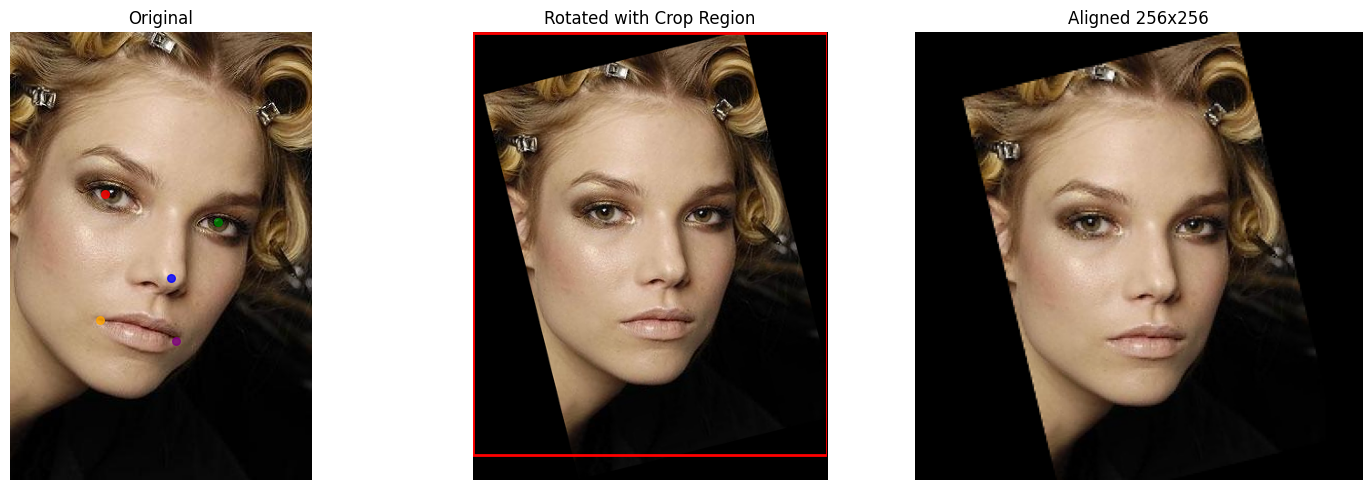

Found 10528 images in cropped_images


Processing images: 100%|██████████| 10528/10528 [11:42<00:00, 14.99it/s]

Processed: 10528/10528 images


In [20]:
# Использование
def main():
    # Загрузка модели
    checkpoint = torch.load(r'I:\Мой диск\Net_project\simple_models\simple_face_landmark_best.pth', map_location='cpu')
    model = StackedHourglassFaceLandmark(
        n_stacks=checkpoint['config']['n_stacks'],
        n_keypoints=5,
        hourglass_channels=checkpoint['config']['hourglass_channels'],
        hourglass_depth=checkpoint['config']['hourglass_depth']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()

    input_dir = 'cropped_images'
    output_dir = 'aligned_faces'

    # Инициализация выравнивателя
    aligner = FaceAligner(model, target_size=256)

    # Одиночное изображение с визуализацией
    aligned_image = aligner.align_single_image('cropped_images/200350.jpg', visualize=True)

    # Пакетная обработка
    #input_dir = '/content/drive/MyDrive/Net_project/cropped_images'
    stats = aligner.align_batch(input_dir, output_dir)

    print(f"Processed: {stats['success']}/{stats['total']} images")

if __name__ == "__main__":
    main()